# 1. Понимание бизнеса

## 1.1 Цель
Предсказать оценку вина по его характеристикам перед выводом продукции на рынок.
Например, покупать определенный сорт вина и какую на него делать наценку

## 1.2 Описание
Производителей вина много, у них есть много сортов с определенными характеристиками.
Чем лучше оценка вина, тем больше посредников захотят поставлять это вино конечным покупателям.
Нужно по характеристикам предсказать оценку вина, чтобы понимать какое вино выводить на рынок


# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [3]:
df_full = pd.read_csv("winequalityN.csv")
df_full.columns = [ x.replace(' ', '_') for x in df_full.columns]

In [4]:
print ('Datasets:' , 'full:' , df_full.shape)

Datasets: full: (6497, 13)


## 2.4 Статистика и визуализации

In [5]:
df_full.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

- type: тип белое/красное
- fixed acidity: фиксированная кислотность. Для красного вина ее оптимальное значение 6-8 г/л, для белого – 7-9 г/л.
- volatile acidity: летучая кислотность. Находится в пределах 0.15 - 0.6
- citric acid: лимонная кислота. Лимонной кислоты может быть до 2 г/дм3.
- residual sugar:  остаточный сахар. может достигать 80 и более. Надо узнать про "Vinho Verde" отдельно.
- chlorides: хлориды
- free sulfur dioxide: свободный диоксид серы. Показаетль до 50
- total sulfur dioxide: общий диоксид серы. Показатель до 300
- density: плотность. В пределаз 0.99 - 1.08
- pH: В виноделии большинство значений pH будет находиться в диапазоне 2,9-3,9, а всё внимание уделяться десятым долям этого спектра.
- sulphates: сульфаты. По нормам до 0.4
- alcohol: градус вина. Для "Vinho Verde" градус от 9 до 13.


<AxesSubplot:>

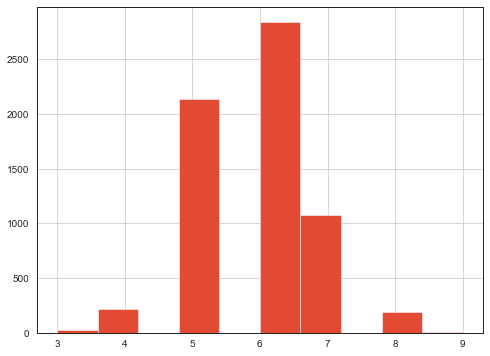

In [6]:
df_full.quality.hist()

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Анализ переменных показывает, что есть некоторые значения, которые выбиваются из типовых значений для вина
Надо проверить на выбросы каждый параметр.

In [7]:
df_full.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Рассмотрим fixed_acidity. Выбросы есть, но наверно это типовые значения для рассматриваемого типа вина. Так как высокие есть только для красного, а слишком низкие только для белого. Т.е. пока эти выбросы удалять не будем.

<AxesSubplot:>

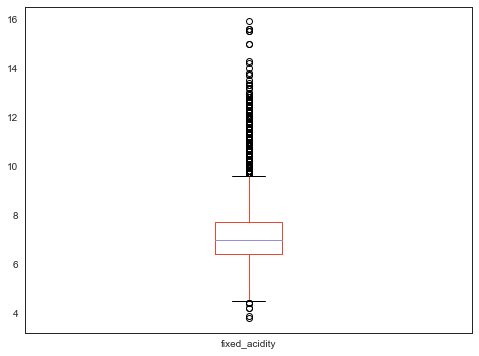

In [8]:
df_full['fixed_acidity'].plot(kind='box')

In [9]:
df_full[df_full.fixed_acidity > 15]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
5340,red,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7
5452,red,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
5453,red,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
5455,red,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
5550,red,15.9,0.360,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.9,5


In [10]:
df_full[df_full.fixed_acidity < 4]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4259,white,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6
4787,white,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8


Рассмотрим volatile_acidity. Есть кандидаты на выбросы. Удалим выброс

<AxesSubplot:>

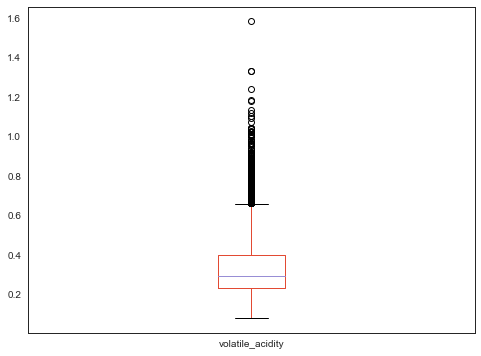

In [11]:
df_full['volatile_acidity'].plot(kind='box')

In [12]:
df_full[df_full.volatile_acidity > 1.5]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
6197,red,7.6,1.58,0.0,2.1,0.137,5.0,9.0,0.99476,3.5,0.4,10.9,3


Рассмотрим citric_acid. Тут есть точно пару выбросов, которые нужно удалить перед обучением модели

<AxesSubplot:>

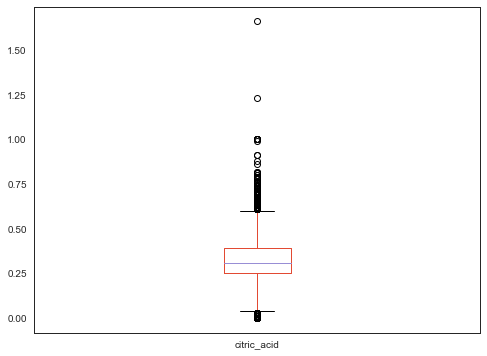

In [13]:
df_full['citric_acid'].plot(kind='box')

In [14]:
df_full[df_full.citric_acid > 1.2]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
745,white,7.4,0.20,1.66,2.1,0.022,34.0,113.0,0.99165,3.26,0.55,12.2,6
3152,white,7.6,0.25,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.1,6


Рассмотрим residual_sugar. Явно выделяющее одно значение надо удалить. Остальное не трогаем.

<AxesSubplot:>

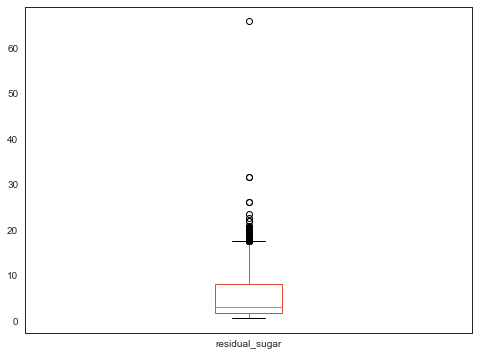

In [15]:
df_full['residual_sugar'].plot(kind='box')

In [16]:
df_full[df_full.residual_sugar > 25]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1653,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
1663,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
2781,white,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6
3619,white,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
3623,white,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6


In [ ]:
Рассмотрим chlorides. Два выделяющихся значения лучше удалить.

<AxesSubplot:>

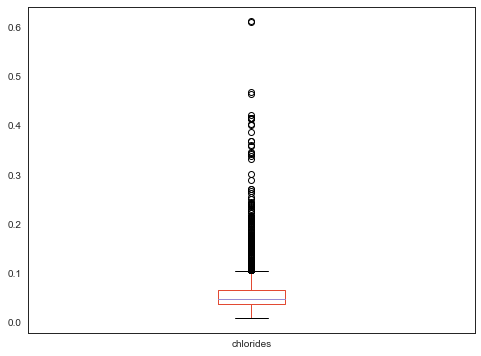

In [17]:
df_full['chlorides'].plot(kind='box')

In [18]:
df_full[df_full.chlorides > 0.5]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
5049,red,9.2,0.52,1.00,3.4,0.610,32.0,69.0,0.9996,2.74,2.00,9.4,4
5156,red,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.9968,3.06,1.26,9.4,5


Расссмотрим free_sulfur_dioxide. Удалим 1 выделяющихся значения

<AxesSubplot:>

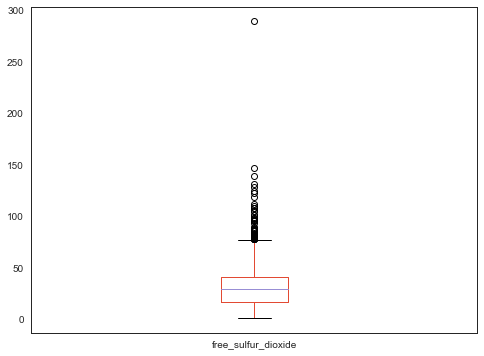

In [19]:
df_full['free_sulfur_dioxide'].plot(kind='box')

In [20]:
df_full[df_full.free_sulfur_dioxide > 200]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4745,white,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


Расссмотрим total_sulfur_dioxide. Удалим 1 выделяющихся значения

<AxesSubplot:>

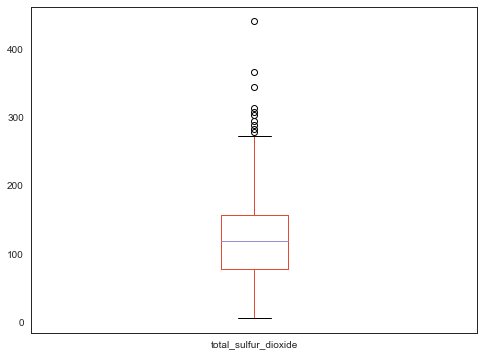

In [21]:
df_full['total_sulfur_dioxide'].plot(kind='box')

In [22]:
df_full[df_full.total_sulfur_dioxide > 330]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1417,white,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.00010,3.04,0.63,11.0,3
2127,white,9.1,0.33,0.38,1.70,0.062,50.5,344.0,0.99580,3.10,0.70,9.5,5
4745,white,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


Рассмотрим sulphates. Раз выбросы идут плотными группами, то скорее всего, что это  особенность этих вин. Удалять ничего не будем.

<AxesSubplot:>

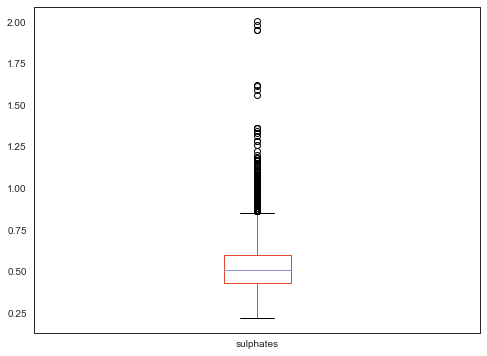

In [23]:
df_full['sulphates'].plot(kind='box')

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны
Есть некоторые фичи, которые очень хорошо коррелируют друг с другом.
Нужно либо убрать какие-то переменные из данных, либо на их основе создать новые переменные.
Можно проконсультироватсья со специалистом по винам или почитать документацию по вину

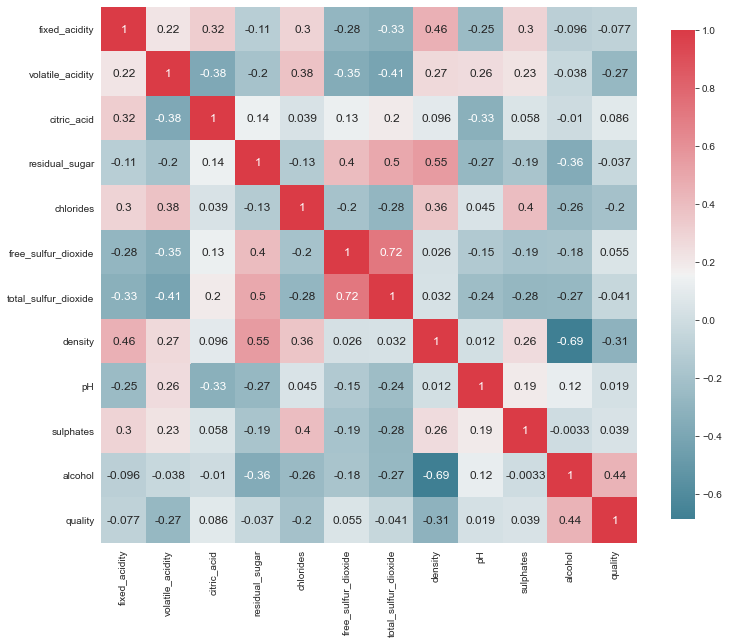

In [24]:
plot_correlation_map( df_full )

free_sulfur_dioxide/total_sulfur_dioxide и residual_sugar/density и alcohol/density имеют значительную корреляцию.
Можно попробовать сделать на их основе новые фичи

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством
Начнем с рассмотрения взаимосвязи алкоголем  и качеством.

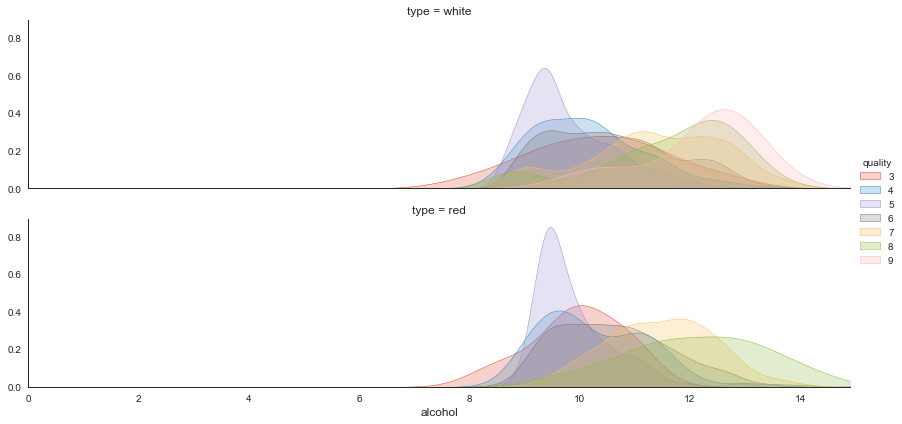

In [25]:
plot_distribution( df_full , var = 'alcohol' , target = 'quality' , row = 'type' )

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменные "type" - категориальные переменные. Поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [26]:
# Create a new variable for every unique value of "type"
wine_type = pd.get_dummies( df_full.type , prefix='type' )
wine_type.head()

,type_red,type_white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


## 3.2 Заполнить пропущенные значения в переменных


In [28]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Fill the Nan values usinf ffill method

In [29]:
df_full.fillna(method='ffill',inplace=True)

In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## 3.3 Feature Engineering &ndash; добавляем новые признаки

### 3.3.1 Считаем  sulfur_dioxide

In [31]:
df_full['sulfur_dioxide'] = np.round(df_full.total_sulfur_dioxide/df_full.free_sulfur_dioxide, 2)

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection

Добавляем тип вина

In [32]:
df_full = df_full.join(wine_type)

Удаляем лишние фичи

In [33]:
df_full.drop(['type', 'free_sulfur_dioxide', 'total_sulfur_dioxide'], axis=1, inplace=True)

Удаляем выбросы

In [34]:
df_full = df_full.loc[df_full.volatile_acidity < 1.5]
df_full = df_full.loc[df_full.citric_acid < 1.25]
df_full = df_full.loc[df_full.residual_sugar < 40]

### 3.4.2 Создание датасетов

Создаем валидационные данные

In [35]:
valid_x = df_full[5199:]
valid_y = valid_x.quality
valid_x.drop(['quality'], axis=1, inplace=True) 

Создаем данные для обучения и теста

In [36]:
X = df_full[:5199]
Y = X.quality
X.drop(['quality'], axis=1, inplace=True)
train_X , test_X , train_y , test_y = train_test_split(X , Y , train_size = .8)

In [37]:
print (train_X.shape , test_X.shape , train_y.shape , test_y.shape , valid_x.shape, valid_y.shape)

(4159, 12) (1040, 12) (4159,) (1040,) (1295, 12) (1295,)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


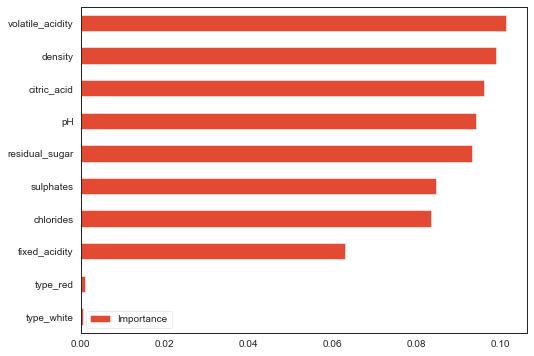

In [38]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели

In [39]:
model_1 = KNeighborsClassifier()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = LinearDiscriminantAnalysis()

## 4.2 Обучение модели

In [40]:
model_1.fit(train_X , train_y)
model_2.fit(train_X , train_y)
model_3.fit(train_X , train_y)
model_4.fit(train_X , train_y)

LinearDiscriminantAnalysis()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [41]:
# Score the model
print (f'Test: {model_1.score(train_X, train_y)} Valid: {model_1.score(valid_x , valid_y)}')
print (f'Test: {model_2.score(train_X, train_y)} Valid: {model_2.score(valid_x , valid_y)}')
print (f'Test: {model_3.score(train_X, train_y)} Valid: {model_3.score(valid_x , valid_y)}')
print (f'Test: {model_4.score(train_X, train_y)} Valid: {model_4.score(valid_x , valid_y)}')

Test: 0.6679490262082232 Valid: 0.4911196911196911
Test: 1.0 Valid: 0.43706563706563706
Test: 1.0 Valid: 0.5405405405405406
Test: 0.5330608319307526 Valid: 0.5552123552123552


LDA справвился "лучше" всех. он хорошо подходит для данных с линейной зависимостью
Алгоритмы на основе решающих деревьев переобучились, что привело к плохим результатам на валидационной выборке.
Значит данные для алгоритма были плохо подготовлены. Кроме того, нужно подобрать гиперпараметры каждой модели, что увеличит качество моделей.

# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [42]:
test_Y = model_4.predict(test_X)
wine_index = test_X.index
test = pd.DataFrame( { 'wine_index': wine_index , 'Quality_pred': test_Y, 'Quality': test_y} )
test.to_csv( 'wine_quality_pred.csv' , index = False )

In [43]:
test.head(20)

,wine_index,Quality_pred,Quality
4028,4028,7,6
4299,4299,5,6
389,389,6,7
2700,2700,6,7
511,511,4,6
884,884,6,6
1485,1485,6,6
2917,2917,7,7
560,560,6,7
1065,1065,6,5
